In [133]:
from syntactic_similarity import syntactic_similarity_driver
from structural_similarity import structural_similarity_driver

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import openpyxl

# generating the scores csv

In [114]:
def generate_scores_csv(df,path):
    firstIndex = path.find("n_")
    finalIndex = path.find("_",firstIndex+2)
    n = int(path[firstIndex+2:finalIndex])

    cols = [
        'task_id', 'prompt', 'sequence_similarity','edit_distance_score',
        'jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient',
        'hamming_distance_score', 'longest_common_subsequence', 'UnifiedDiff','TreeDiff'
    ] + [f'pass_rate_{i}' for i in range(n+1)]


    final = pd.DataFrame(columns = cols)

    #iterating over the rows of the dataframe
    for index, row in df.iterrows():
        #getting the reference and the generated text
        generated_codes = list(row[[f'code_{i}' for i in range(n+1)]])
            
        #computing the structural similarity
        _, structural_similarity_scores_dict,_ = structural_similarity_driver(generated_codes)
        
        #computing the syntactic similarity
        _, syntactic_similarity_scores_dict,_ = syntactic_similarity_driver(generated_codes)
        
        #dict to store the data
        dict = {'task_id': row['task_id'], 'prompt': row['prompt']}

        for i in range(n+1):
            dict['pass_rate_'+str(i)] = row['pass_rate_'+str(i)]
            
        #appending the syntactic similarity scores to the dict
        for key in syntactic_similarity_scores_dict.keys():
            dict[key] = syntactic_similarity_scores_dict[key]

        #appending the structural similarity scores to the dict
        for key in structural_similarity_scores_dict.keys():
            dict[key] = structural_similarity_scores_dict[key]

        temp = pd.DataFrame(dict, index=[0])

        #concatenating the dataframes
        final = pd.concat([final, temp], ignore_index=True)
    
    path = path.replace(".csv","_sim_score.csv")
    path = path.replace("RESULTS","RESULTS/final scores")
    final.to_csv(path, index=False)

# reading the files

In [163]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('./RESULTS/*.csv')

# Loop over the files and read them into pandas DataFrames
for file in csv_files:
    df = pd.read_csv(file)
    generate_scores_csv(df,file)
    print("Scores generated for ", file)

print("Scores generated successfully")

/tmp/ipykernel_35193/1187370557.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/dataset_HumanEval_model_gpt-4-turbo-preview_n_5_tempr_0_temps_1_trial_1.csv


ValueError: invalid literal for int() with base 10: '/RESULTS/stats.cs'

# visualizations

In [185]:
def visualize(df,path):
    print("Visualizing the scores of the file ",path)
    firstIndex = path.find("n_")
    finalIndex = path.find("_",firstIndex+2)
    n = int(path[firstIndex+2:finalIndex])
    # print(df.index)

    df['avg_pass_rate'] = df[[f'pass_rate_{i}' for i in range(n+1)]].mean(axis=1)
    #sort by avg pass rate
    df = df.sort_values(by='avg_pass_rate',ascending=True)
    #scoring columns
   # scores_columns = ['sequence_similarity','edit_distance_score','jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient','hamming_distance_score','longest_common_subsequence','UnifiedDiff','TreeDiff']
    scores_columns = ['sequence_similarity','UnifiedDiff']

    #print the number of data points that has the avg pass rate of 100
    print("number of data points that has the avg pass rate = 100 ",len(df[df['avg_pass_rate'] == 100] )/ len(df))

    corrs=-2
    file = ""
    #plot the avg pass rate with the task id and a score metrics
    for score in scores_columns:
        print("The correlation between the average pass rate and",score,"is",df['avg_pass_rate'].corr(df[score]))
        if df['avg_pass_rate'].corr(df[score]) > corrs:
            corrs = df['avg_pass_rate'].corr(df[score])
            file = path

        #plot the avg pass rate wih color red and sequence similarity with color blue
        plt.figure(figsize=(25,10))
        plt.scatter(df["task_id"] ,df[score]*100,color='blue')
        plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
        plt.xlabel('Task ID')
        #rotate the x axis labels
        plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
        plt.ylabel('Scores')
        plt.legend([score,'Average Pass Rate'])
        display_path = path.split("/")[-1]
        display_path = display_path.replace("_trial_1_sim_score.csv","")
        plt.title('Average Pass Rate vs ' + score + " \nConfig: " + display_path)
       # plt.grid()
        plt.show()

    print("Visualizing the scores of the file ",path," completed")
    print("--------------------------------------------------------------------")


    print("The file with the highest correlation between the average pass rate and a score metric is ",file," with a correlation of ",corrs)

    


# stats

In [186]:
def generate_stats(df,path):
    print("generating stats of the file ",path)
    firstIndex = path.find("n_")
    finalIndex = path.find("_",firstIndex+2)
    n = int(path[firstIndex+2:finalIndex])

    df['avg_pass_rate'] = df[[f'pass_rate_{i}' for i in range(n+1)]].mean(axis=1)
    #sort by avg pass rate
    df = df.sort_values(by='avg_pass_rate',ascending=True)
    #scoring columns
    scores_columns = ['sequence_similarity','edit_distance_score','jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient','hamming_distance_score','longest_common_subsequence','UnifiedDiff','TreeDiff']
    dict = {}
    #plot the avg pass rate with the task id and a score metrics
    for score in scores_columns:
        dict[score] = df['avg_pass_rate'].corr(df[score]).round(2)
    
    return dict


        


# looping to get the visuals and stats

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_10_tempr_0_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.32926829268292684
The correlation between the average pass rate and sequence_similarity is 0.28315635016063695


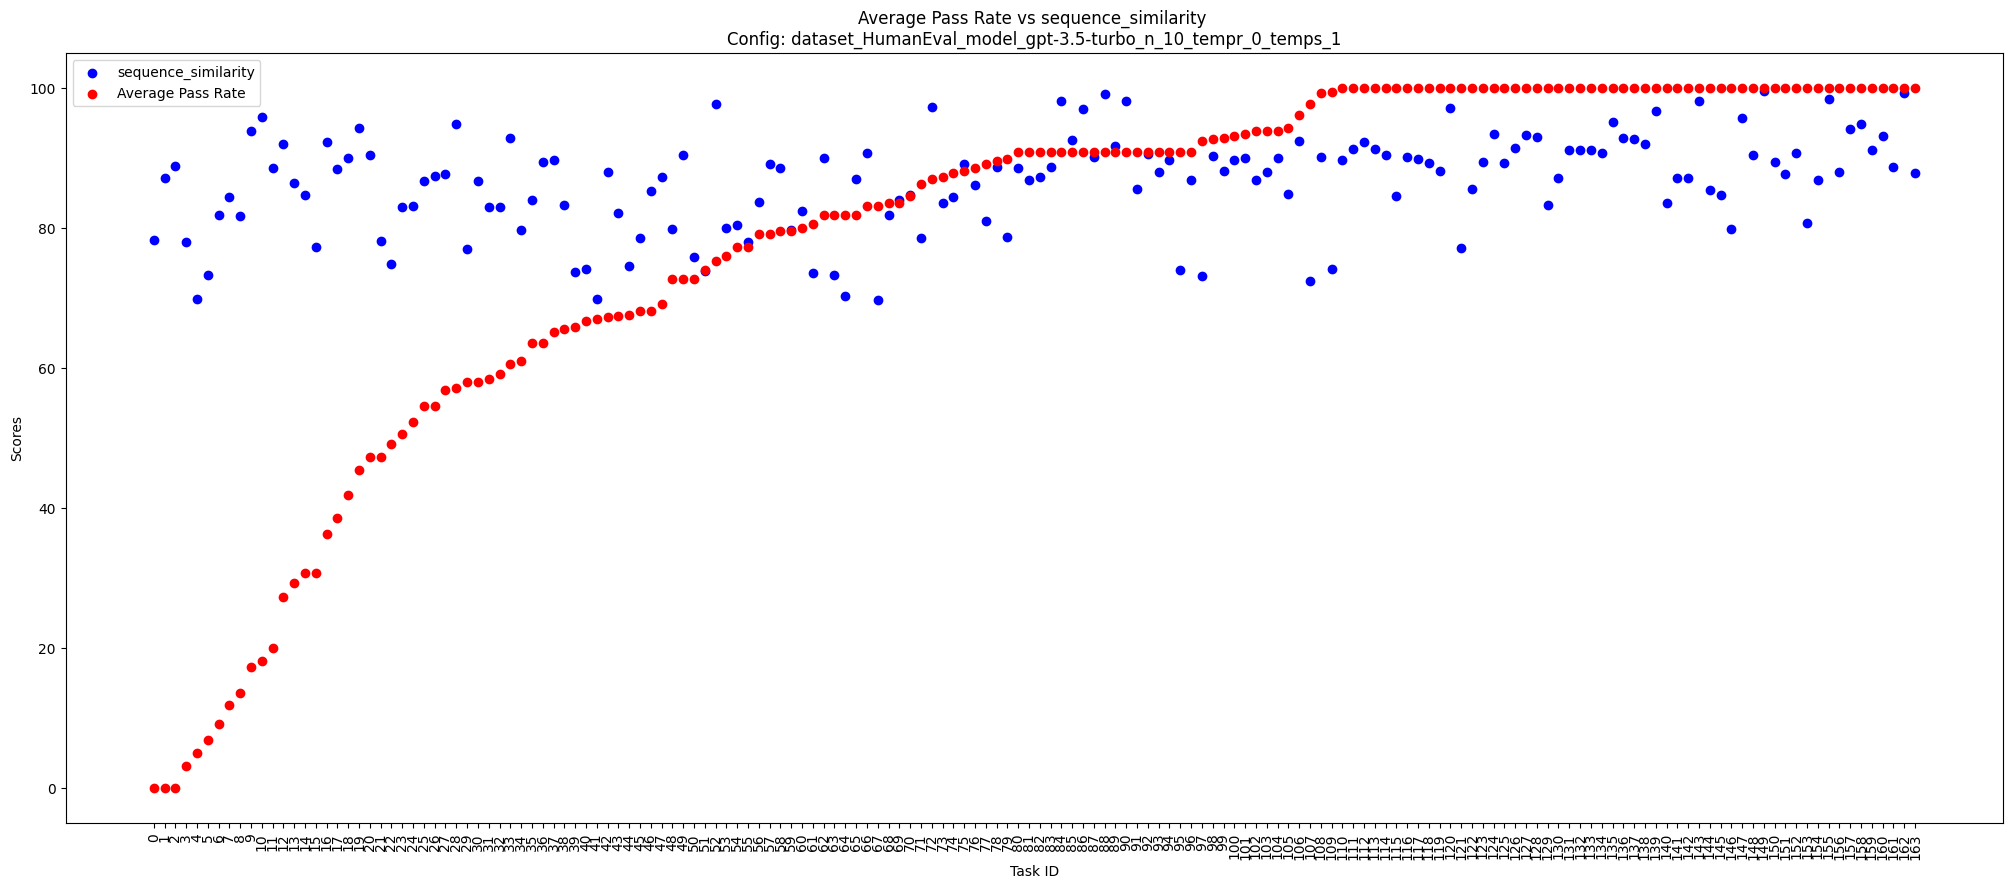

The correlation between the average pass rate and UnifiedDiff is 0.3044672321486433


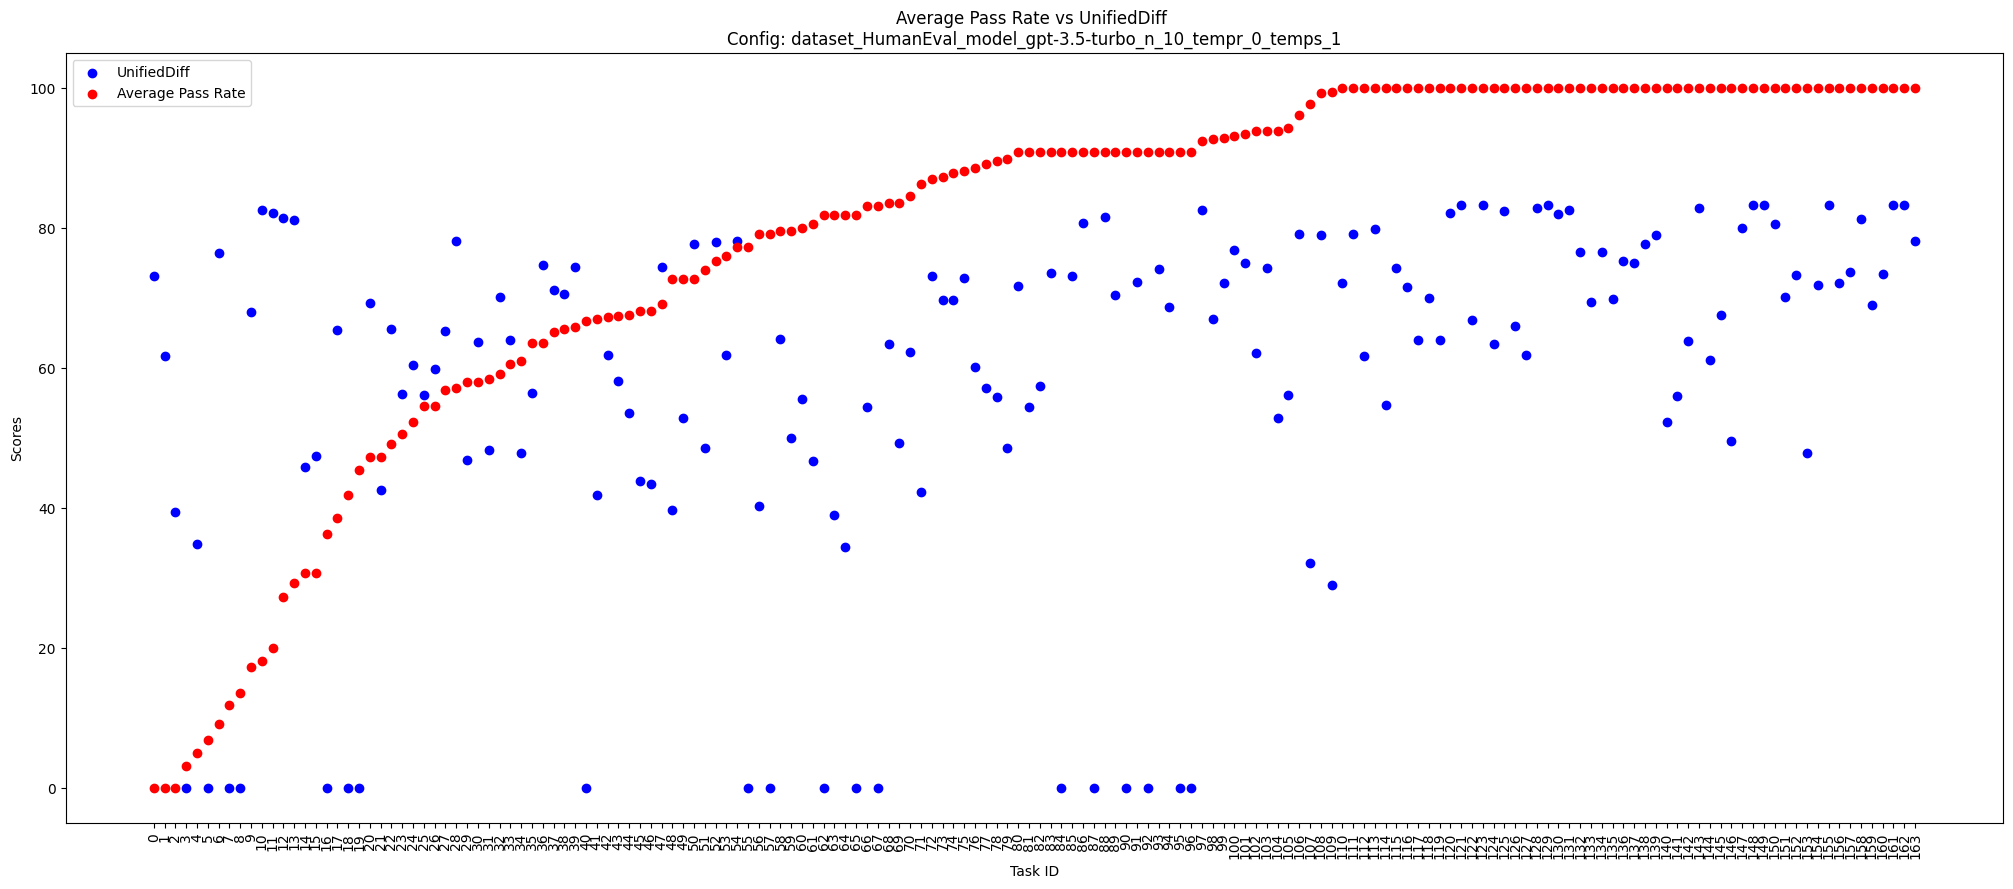

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_10_tempr_0_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_10_tempr_0_temps_1_trial_1_sim_score.csv  with a correlation of  0.3044672321486433
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_10_tempr_0_temps_1_trial_1_sim_score.csv
Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.4451219512195122
The correlation between the average pass rate and sequence_similarity is 0.2816045555138829


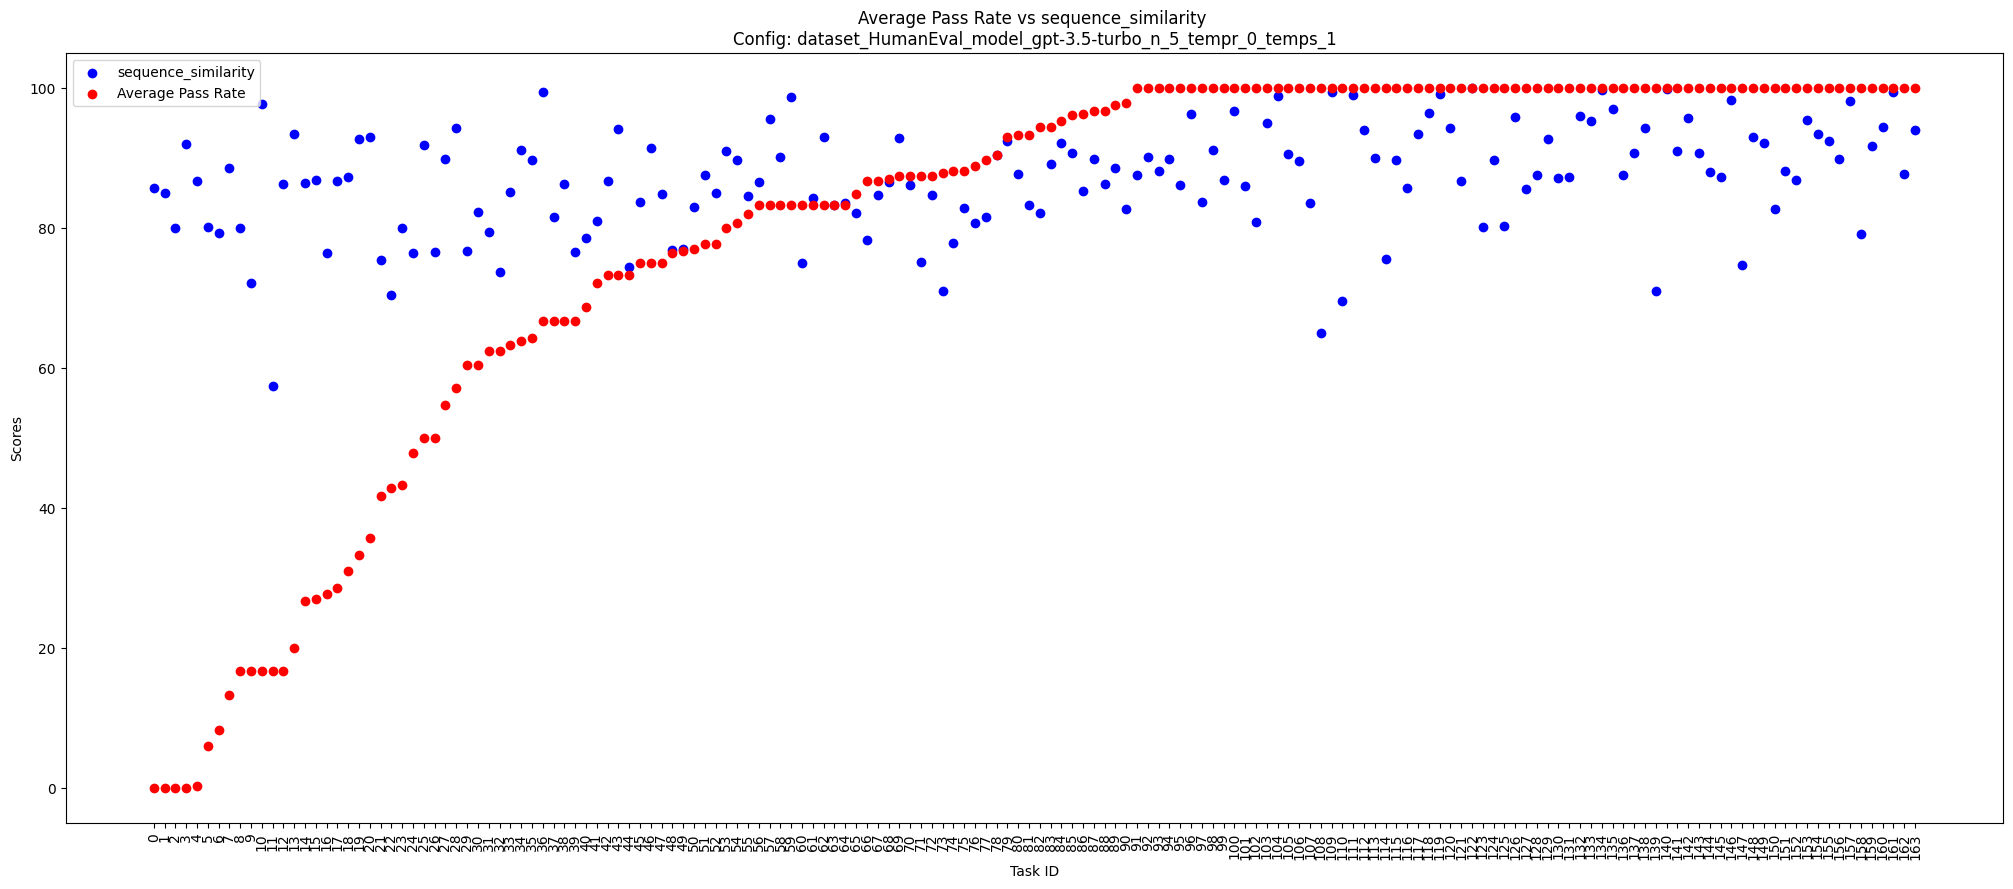

The correlation between the average pass rate and UnifiedDiff is 0.2546562061066837


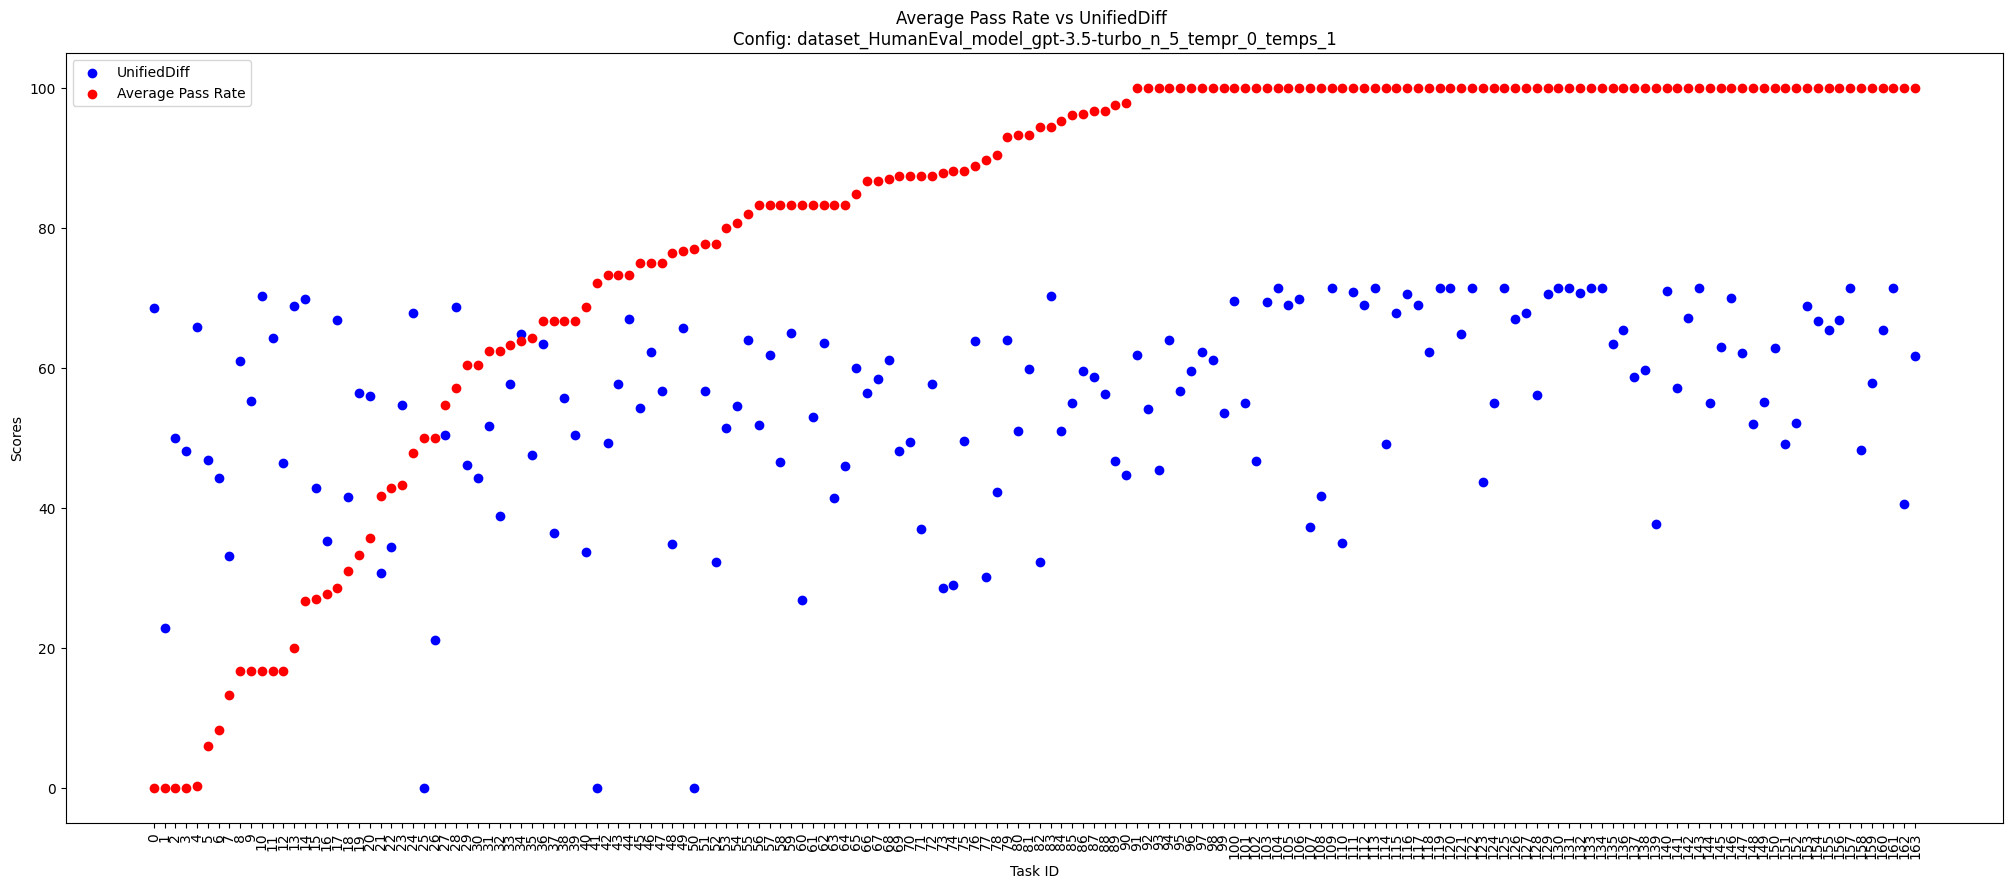

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv  with a correlation of  0.2816045555138829
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv
Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_3_tempr_0_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.5060975609756098
The correlation between the average pass rate and sequence_similarity is 0.23397753418888778


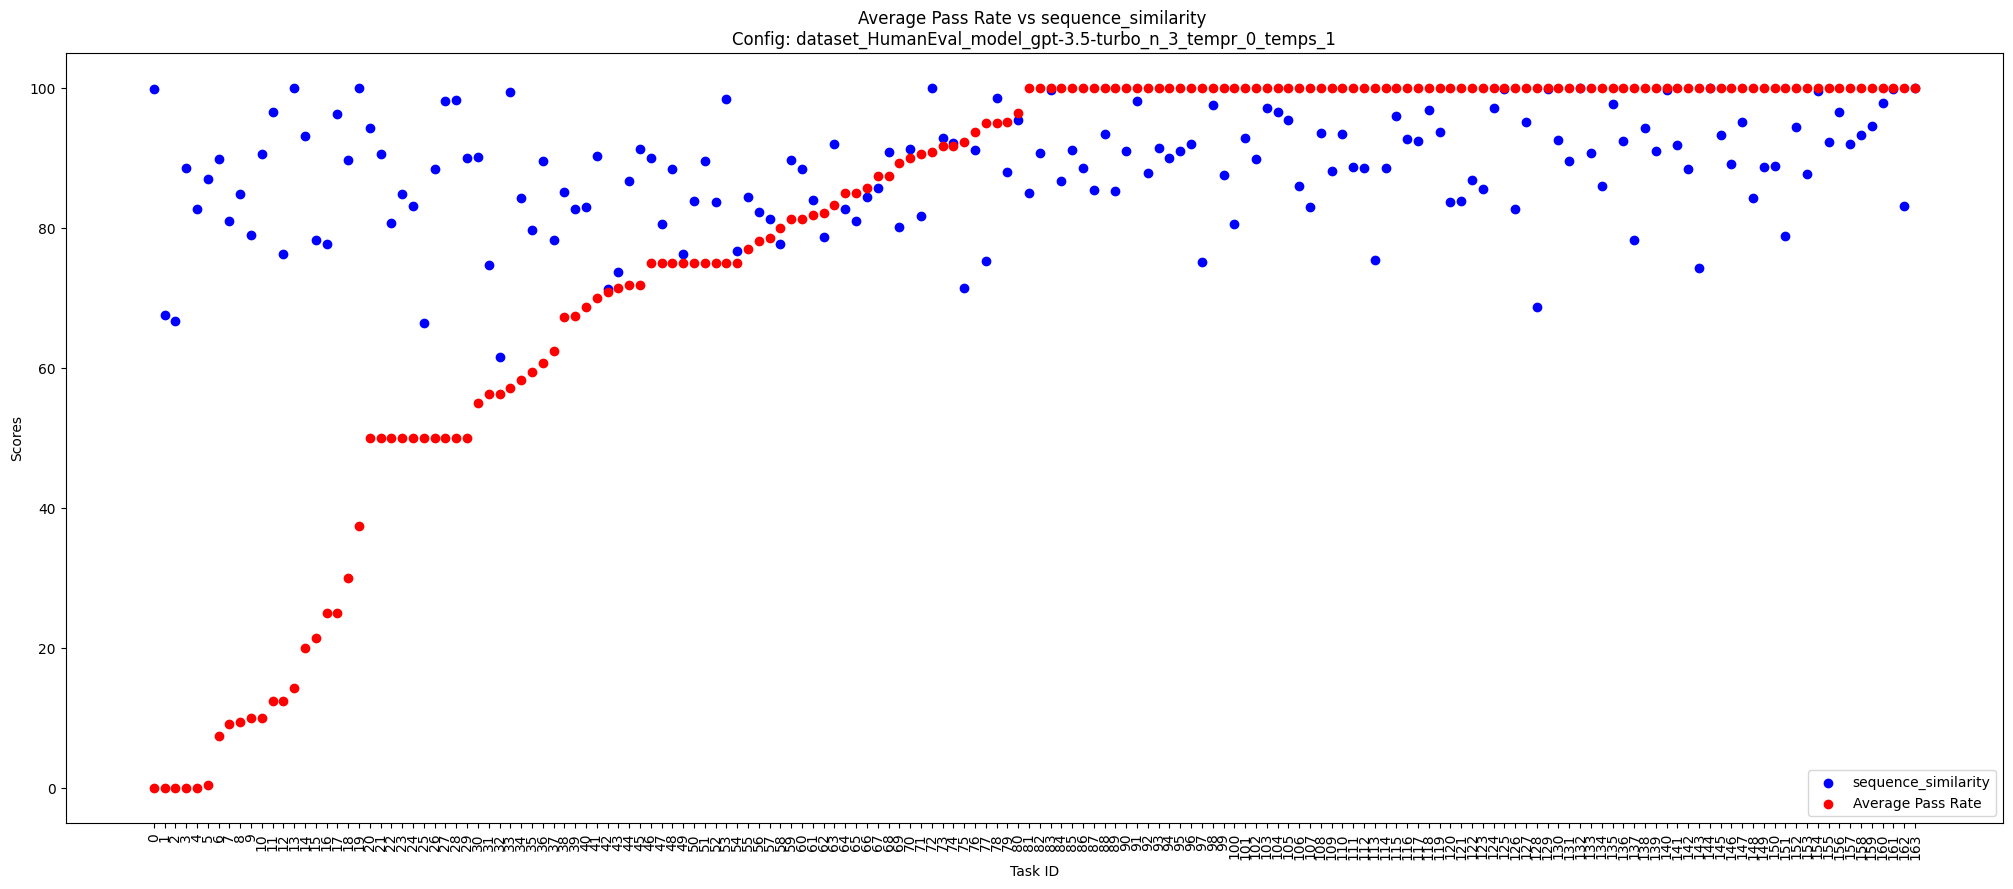

The correlation between the average pass rate and UnifiedDiff is 0.29853894109914025


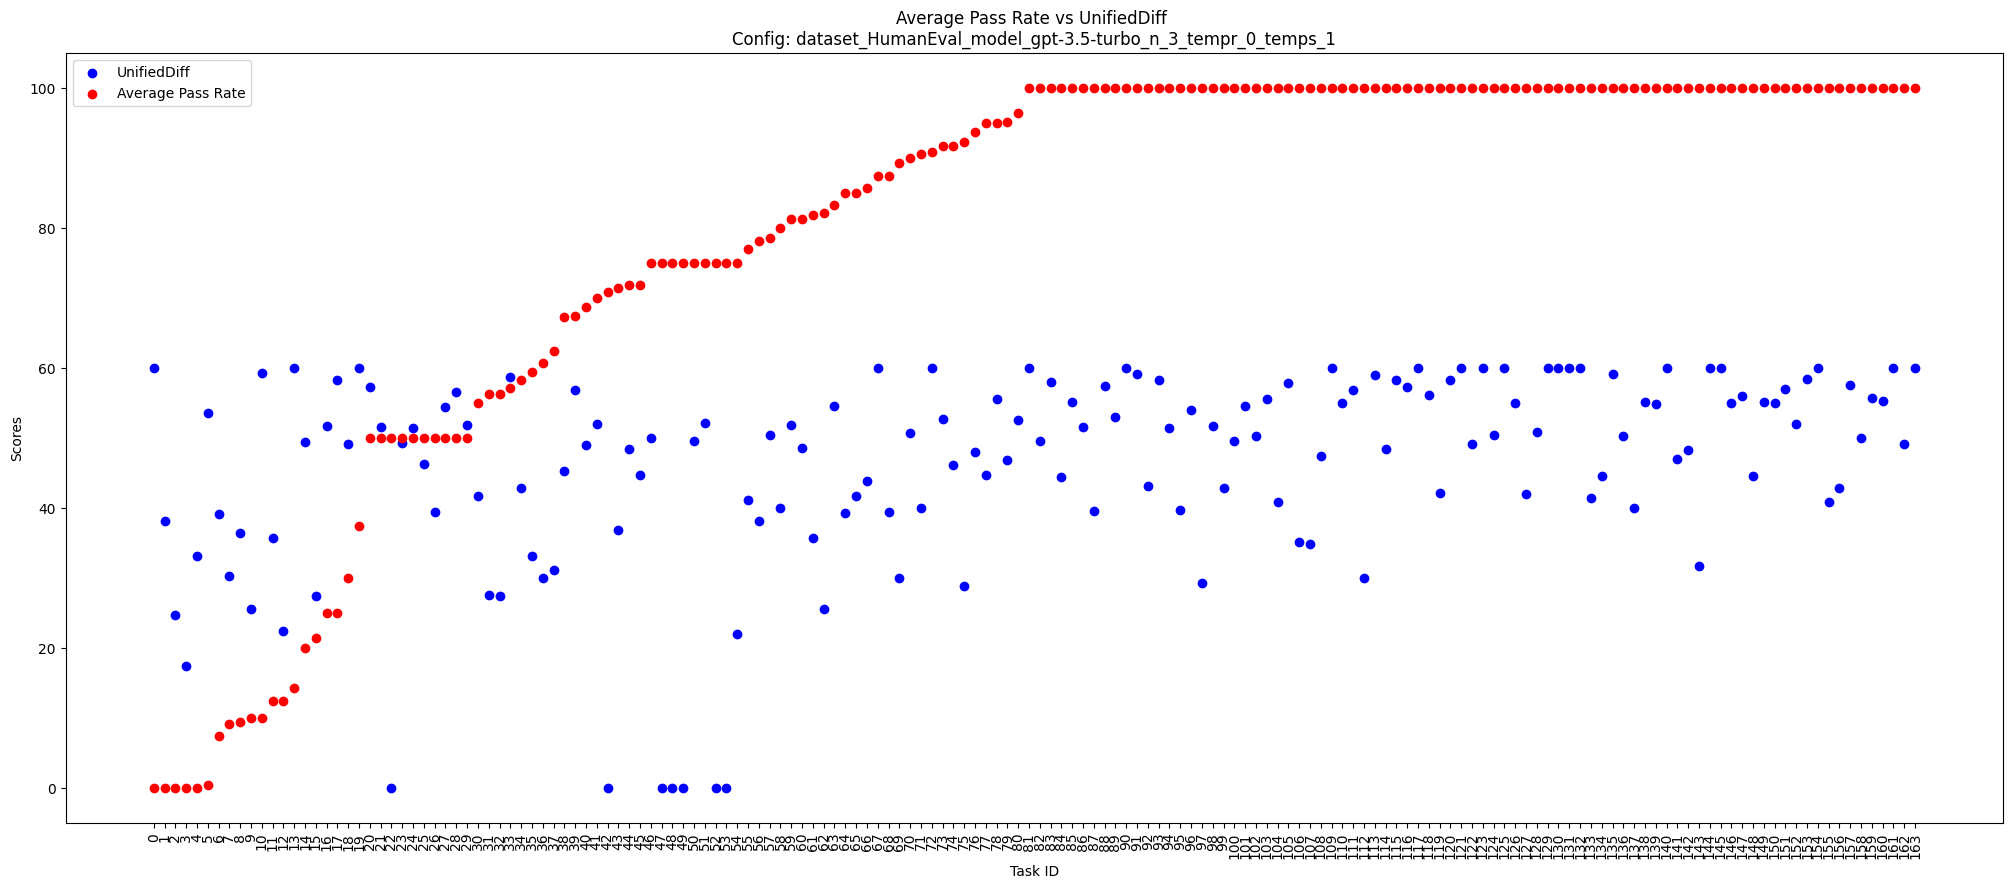

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_3_tempr_0_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_3_tempr_0_temps_1_trial_1_sim_score.csv  with a correlation of  0.29853894109914025
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_3_tempr_0_temps_1_trial_1_sim_score.csv
Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.2621951219512195
The correlation between the average pass rate and sequence_similarity is 0.47310255844320515


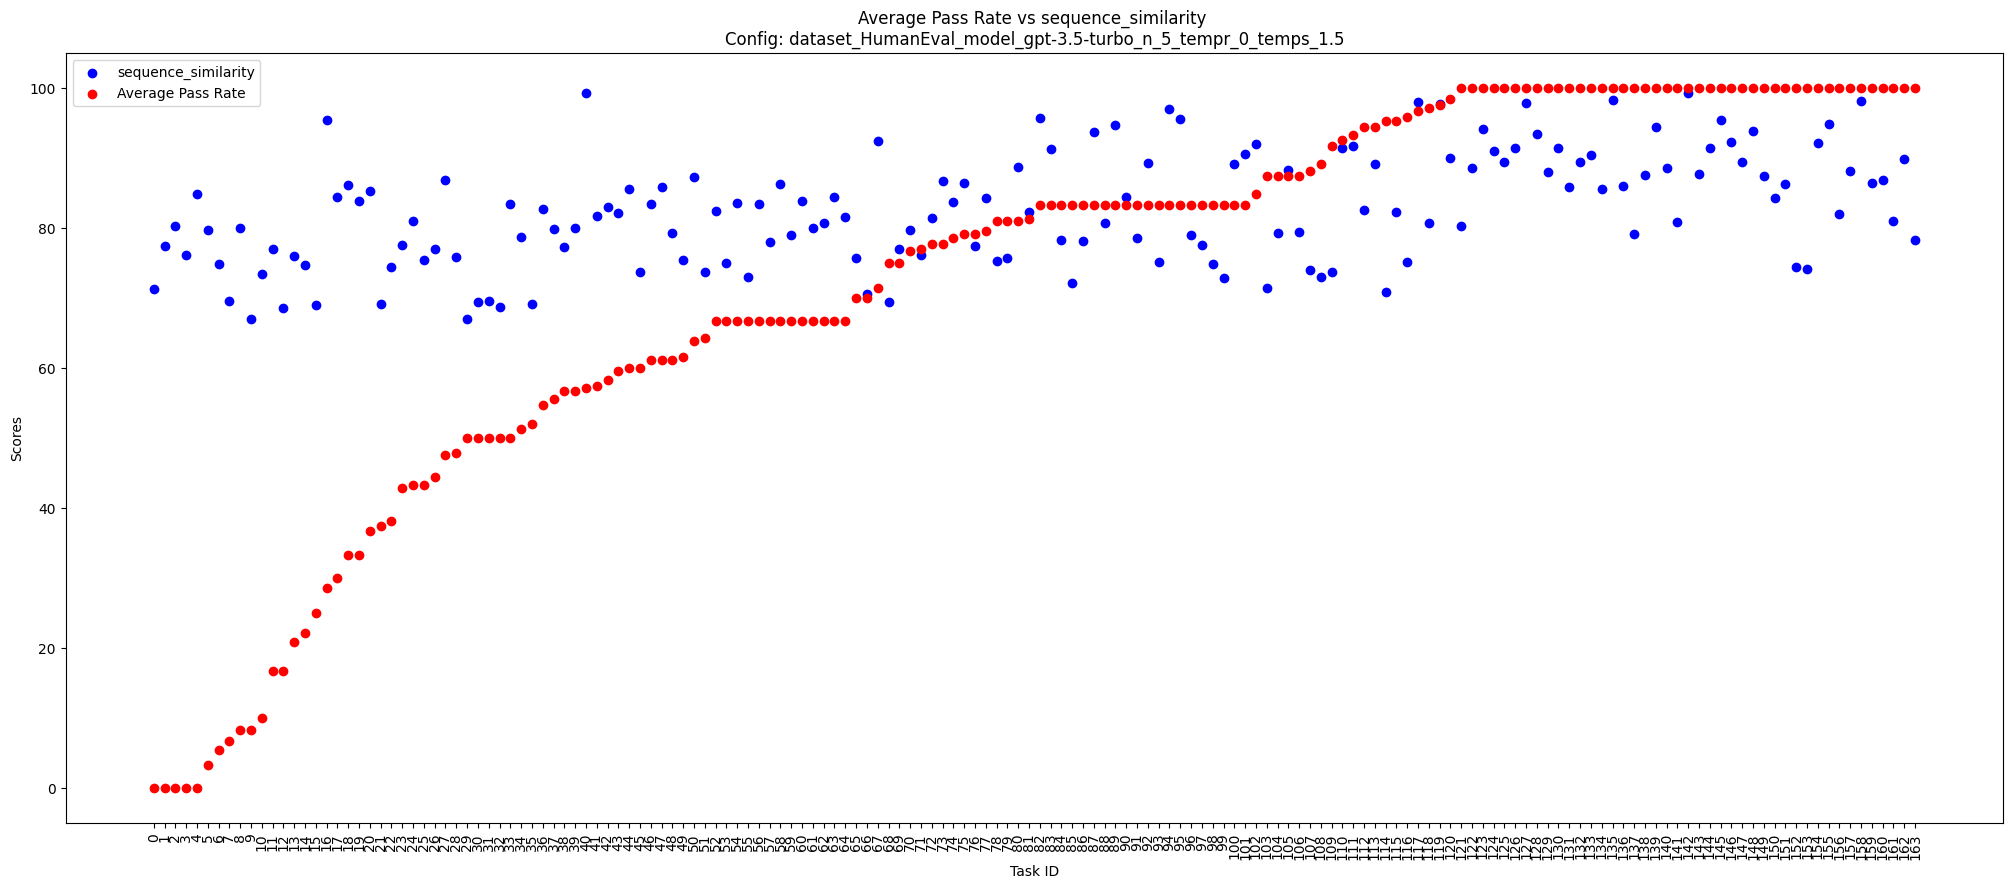

The correlation between the average pass rate and UnifiedDiff is 0.4178569734157659


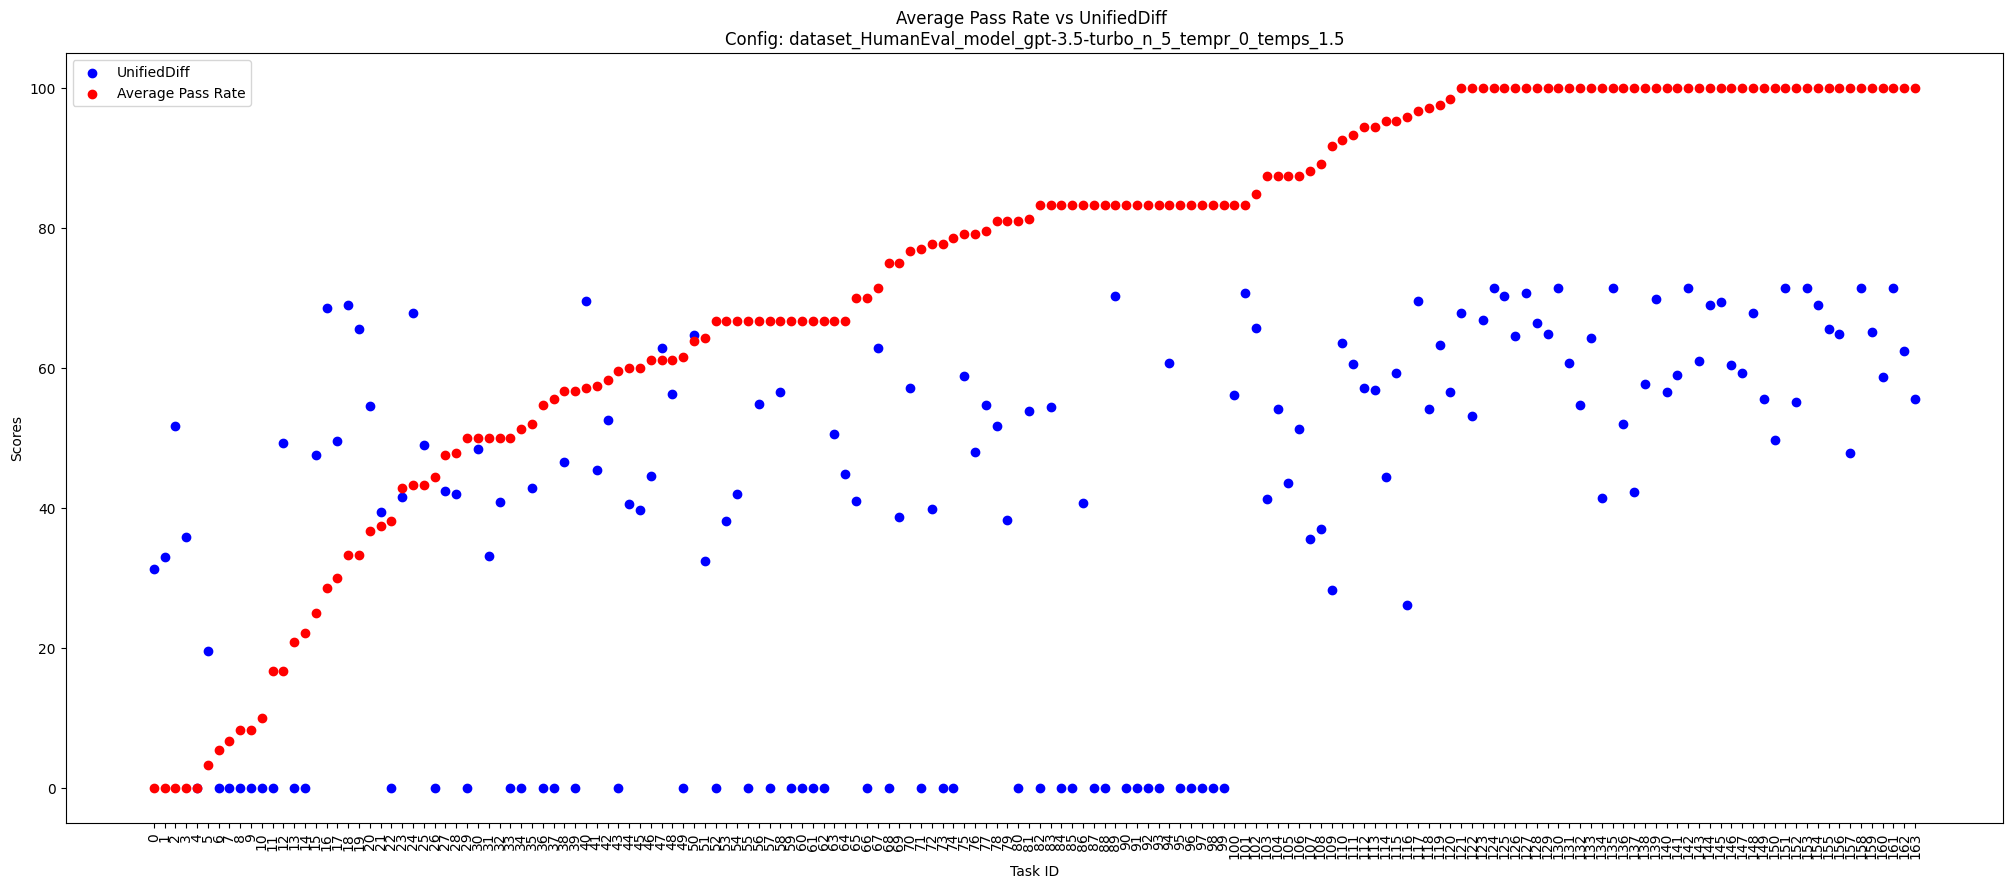

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv  with a correlation of  0.47310255844320515
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv
Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.2804878048780488
The correlation between the average pass rate and sequence_similarity is 0.35080310863508385


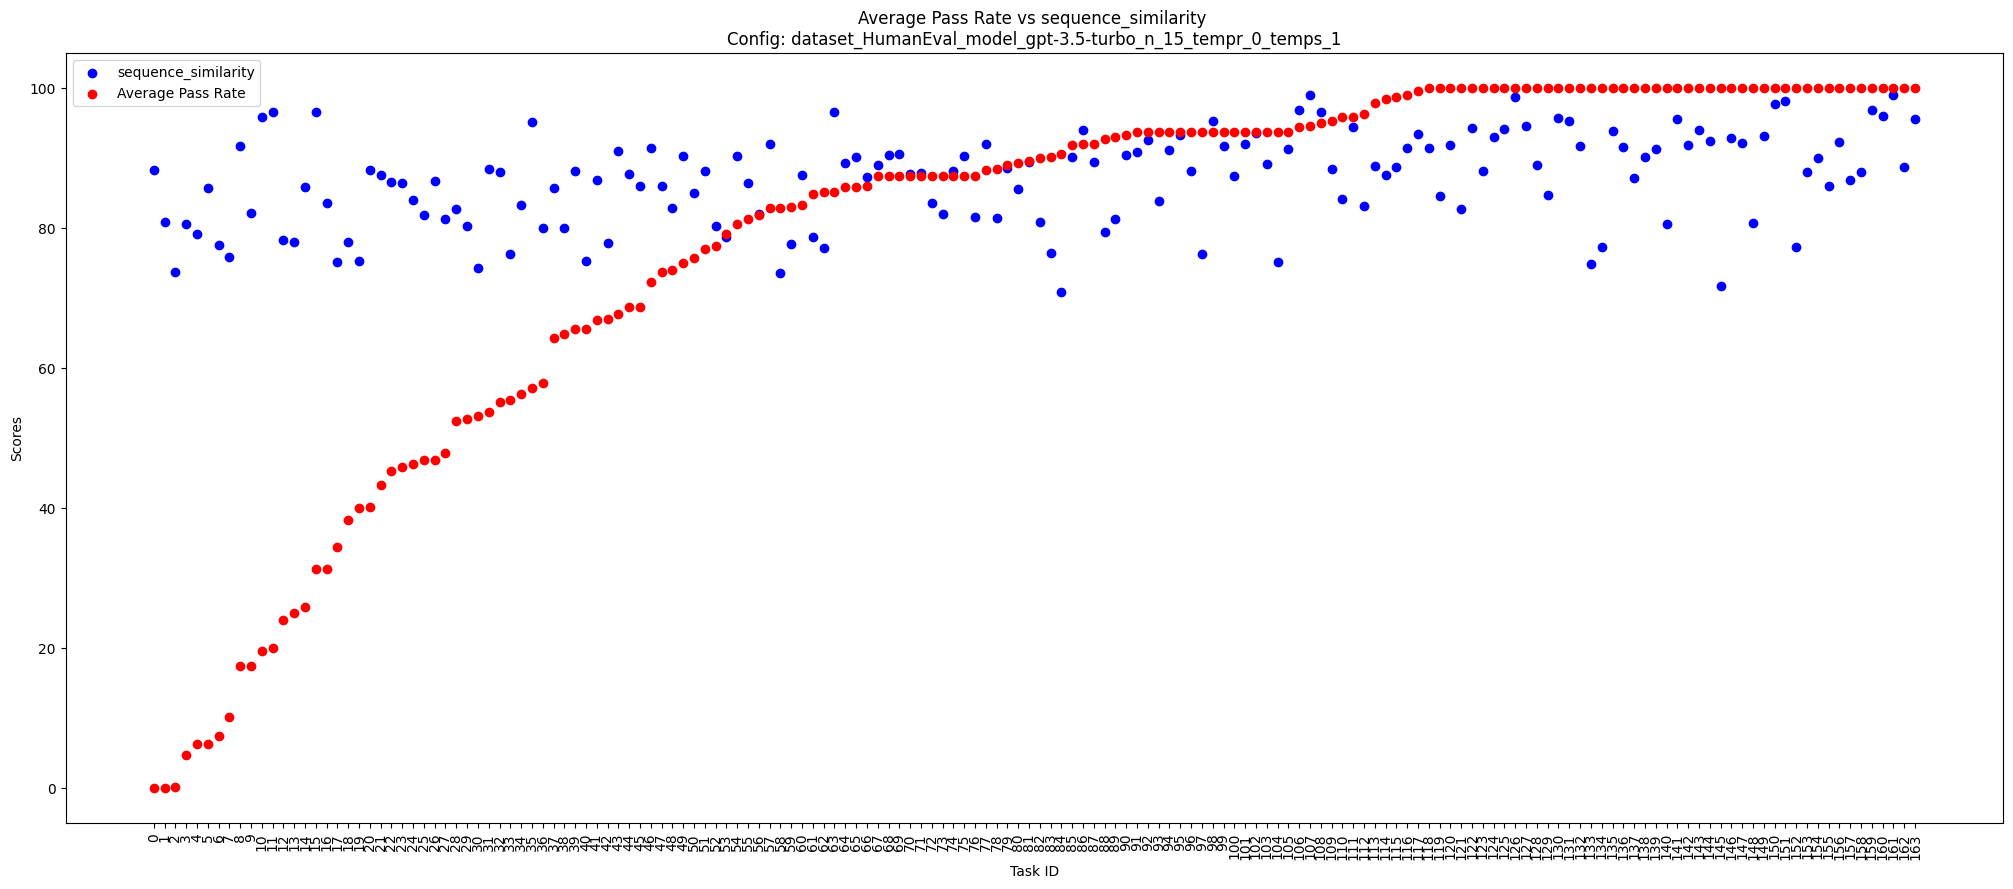

The correlation between the average pass rate and UnifiedDiff is 0.2662247262249974


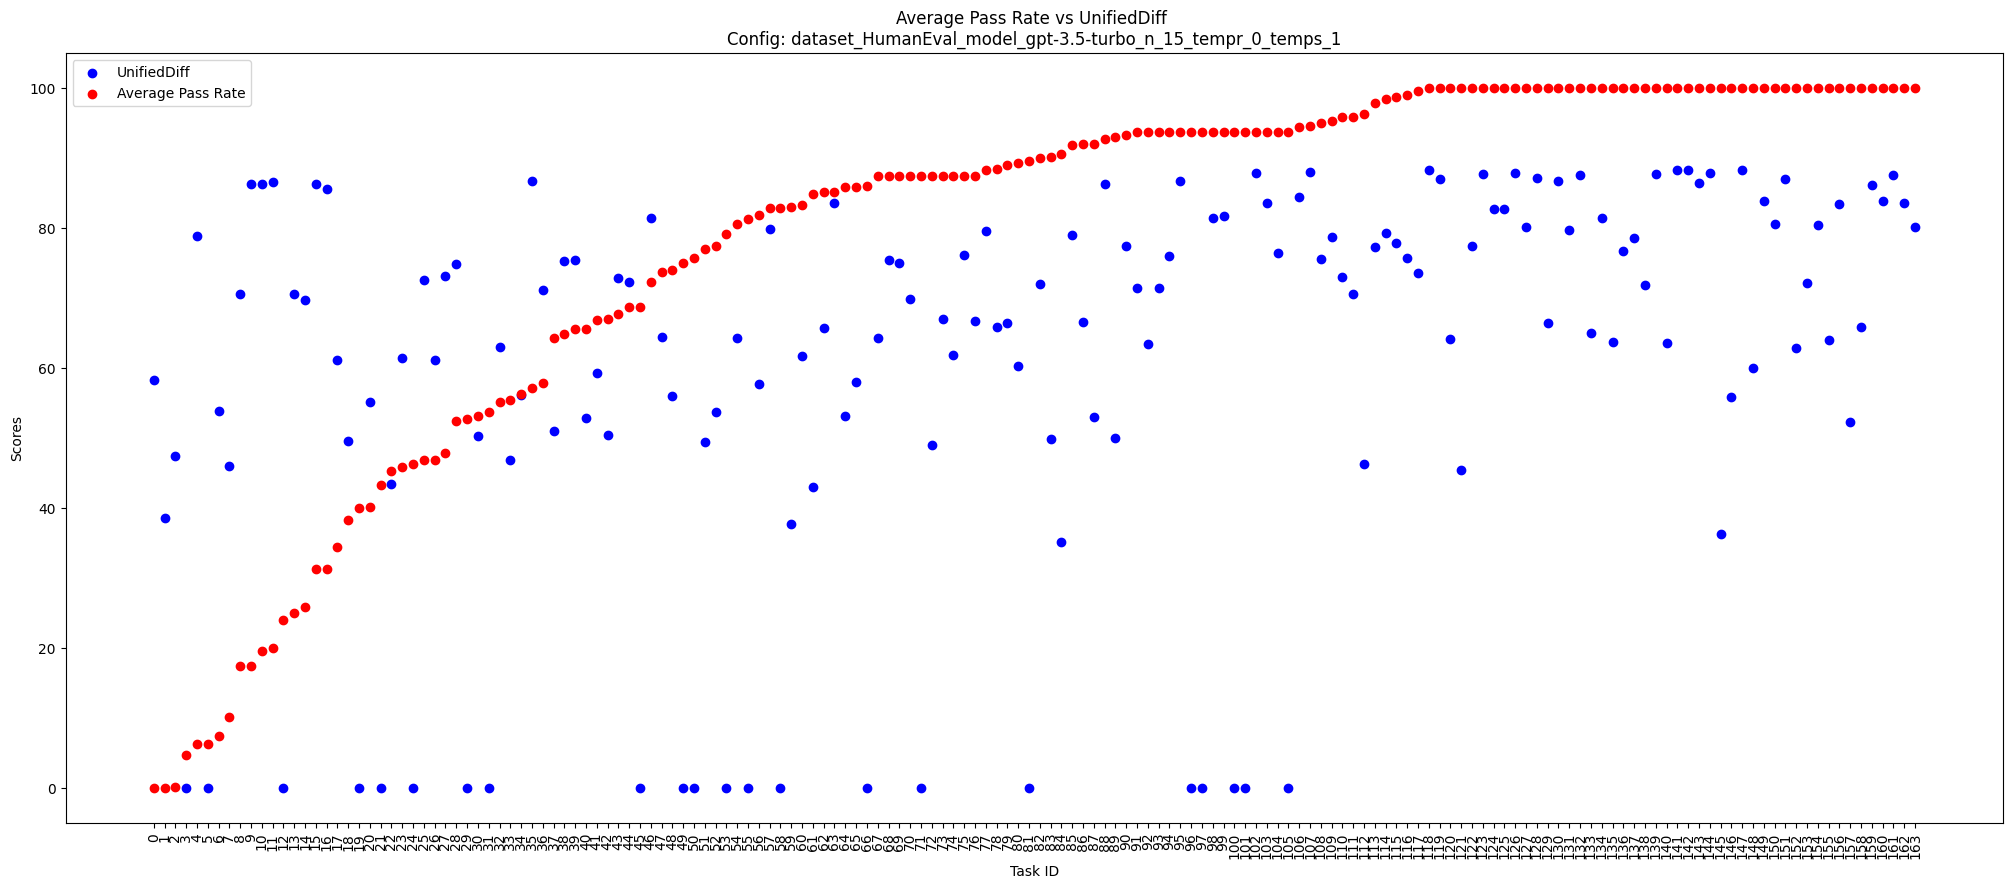

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv  with a correlation of  0.35080310863508385
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv
Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-4-turbo-preview_n_5_tempr_0_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.7134146341463414
The correlation between the average pass rate and sequence_similarity is 0.09440268486403453


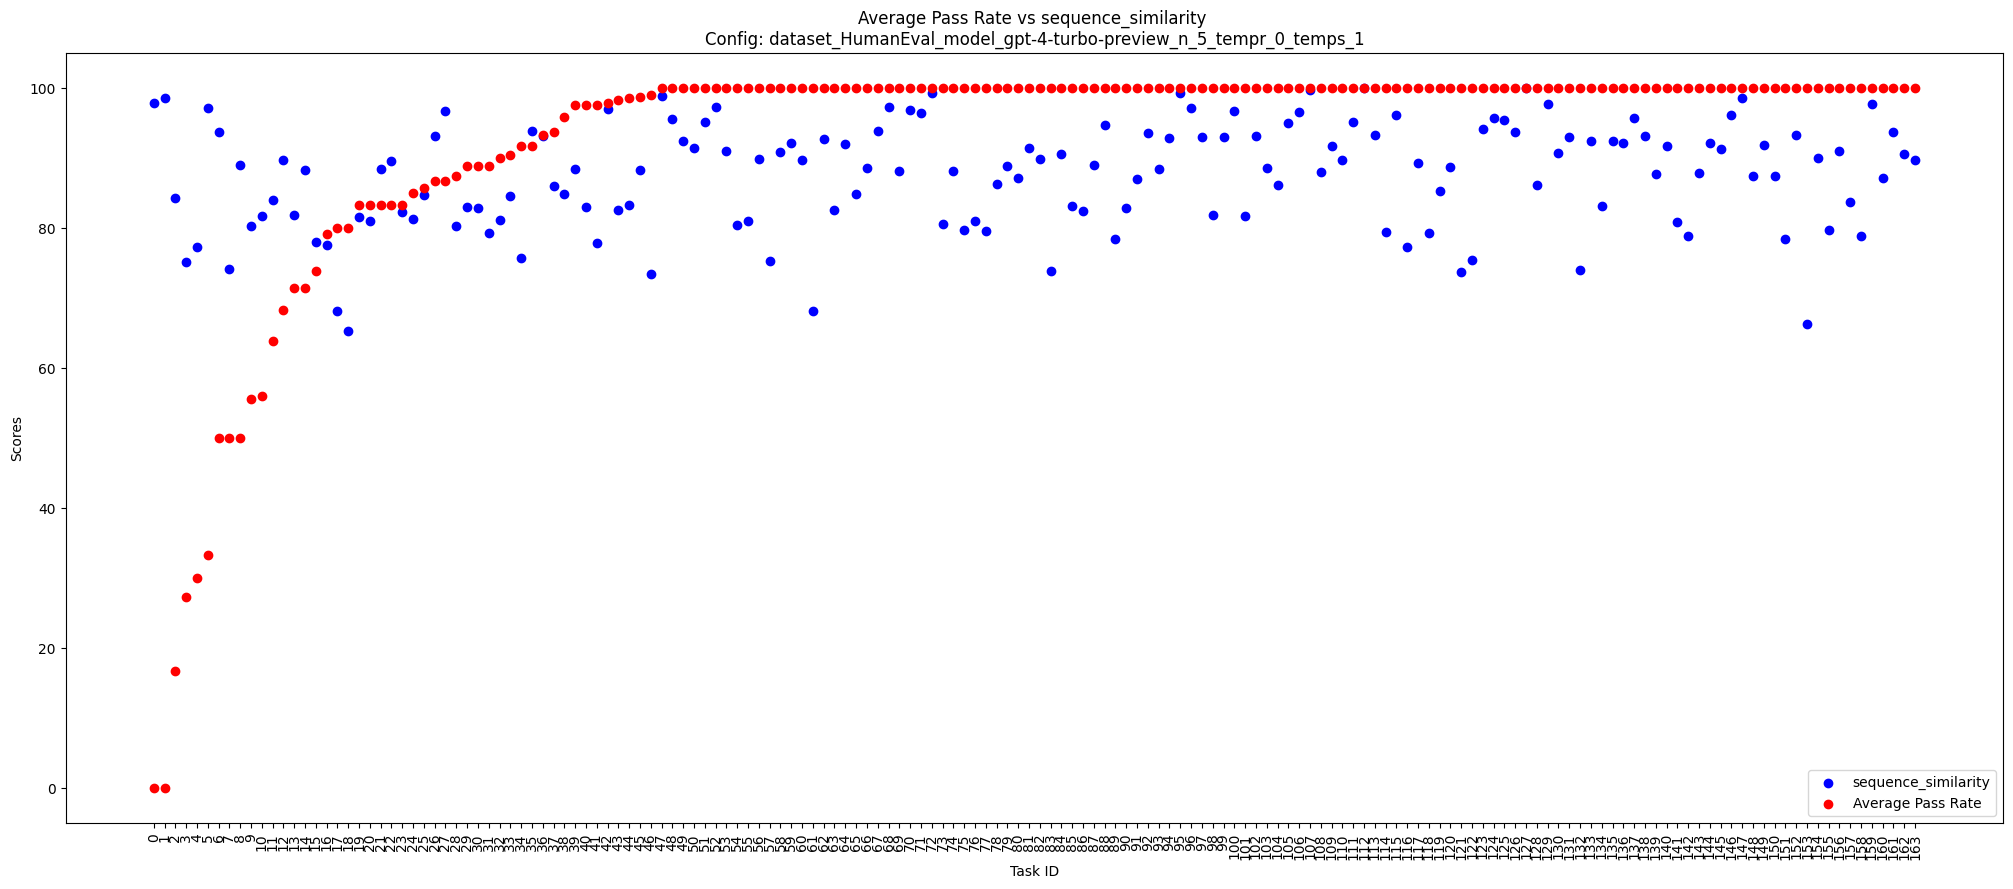

The correlation between the average pass rate and UnifiedDiff is 0.15357497930573605


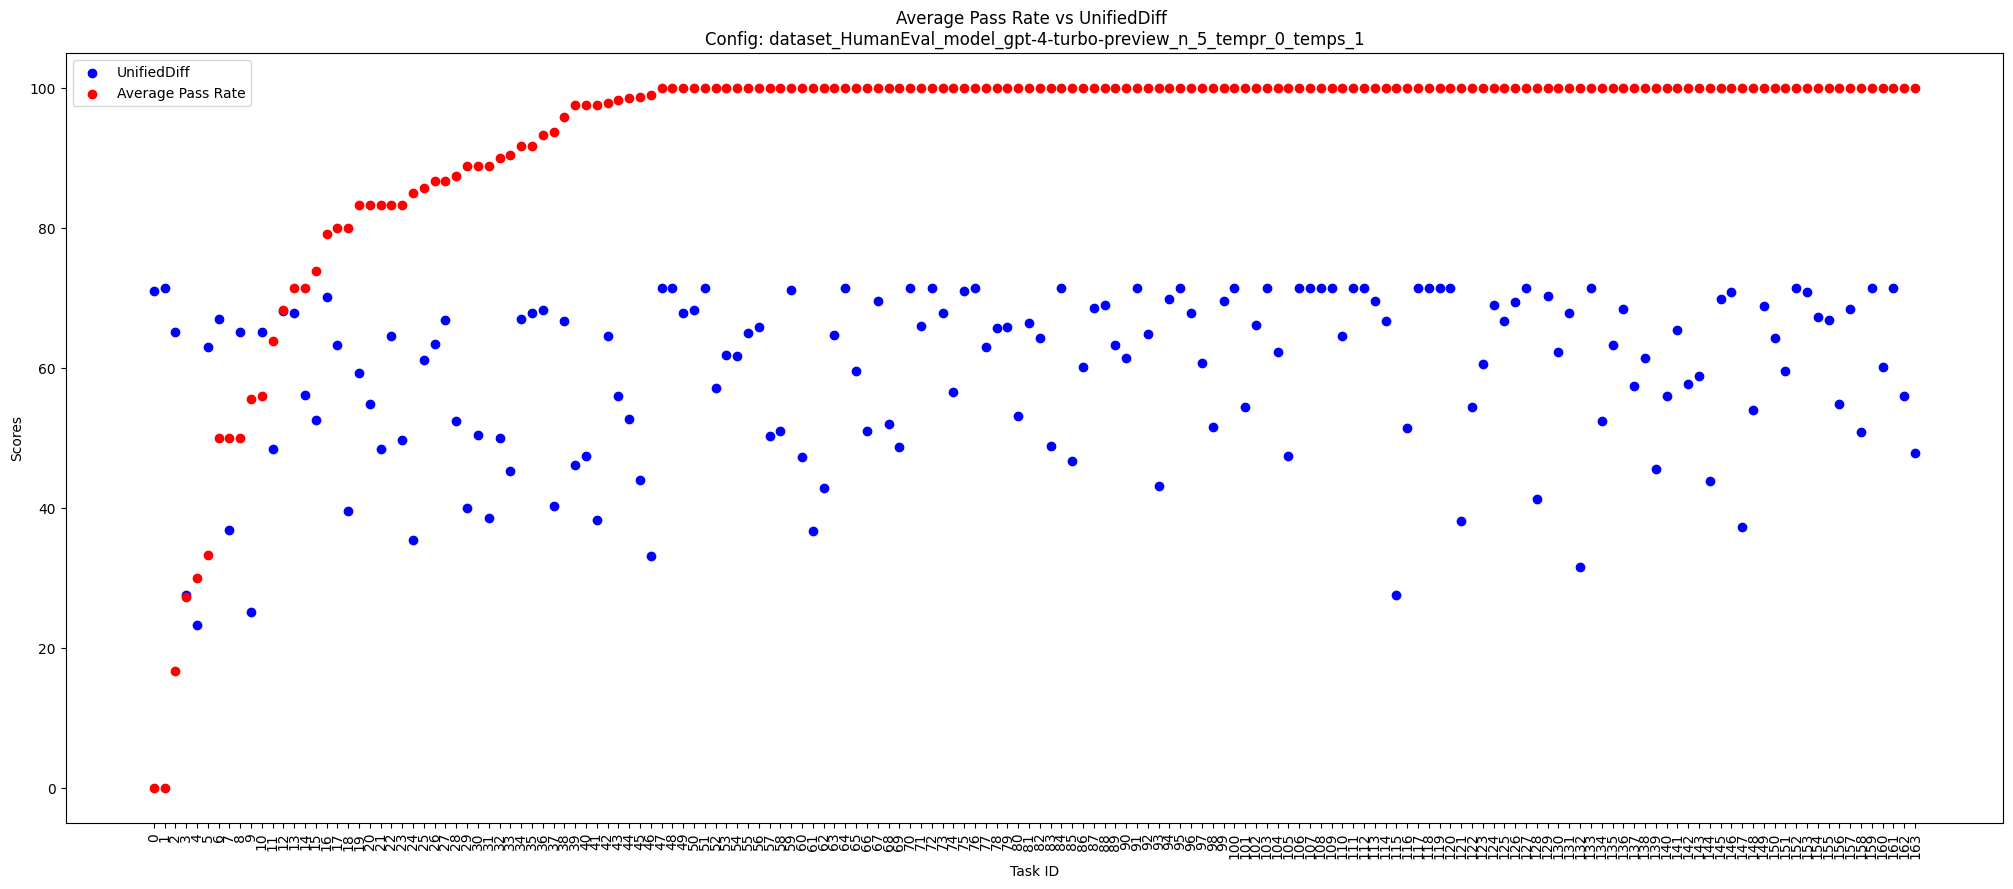

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-4-turbo-preview_n_5_tempr_0_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-4-turbo-preview_n_5_tempr_0_temps_1_trial_1_sim_score.csv  with a correlation of  0.15357497930573605
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-4-turbo-preview_n_5_tempr_0_temps_1_trial_1_sim_score.csv
Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.43902439024390244
The correlation between the average pass rate and sequence_similarity is 0.20527841268310526


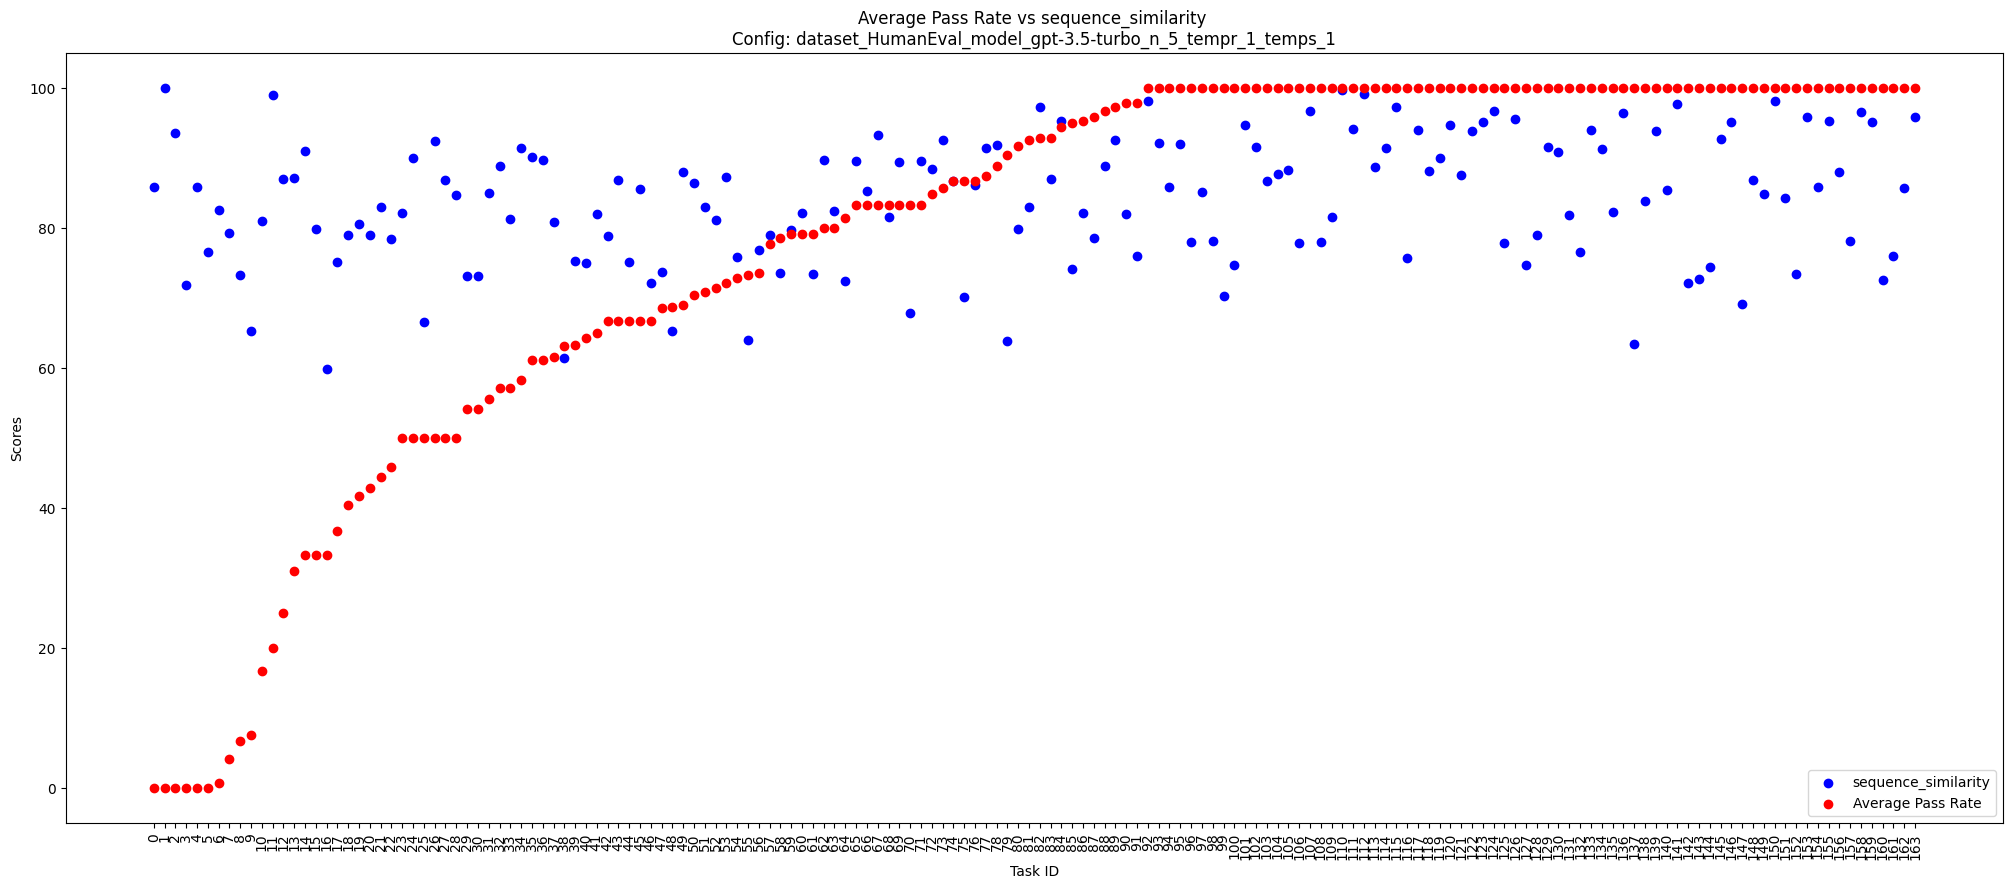

The correlation between the average pass rate and UnifiedDiff is 0.2797874988226724


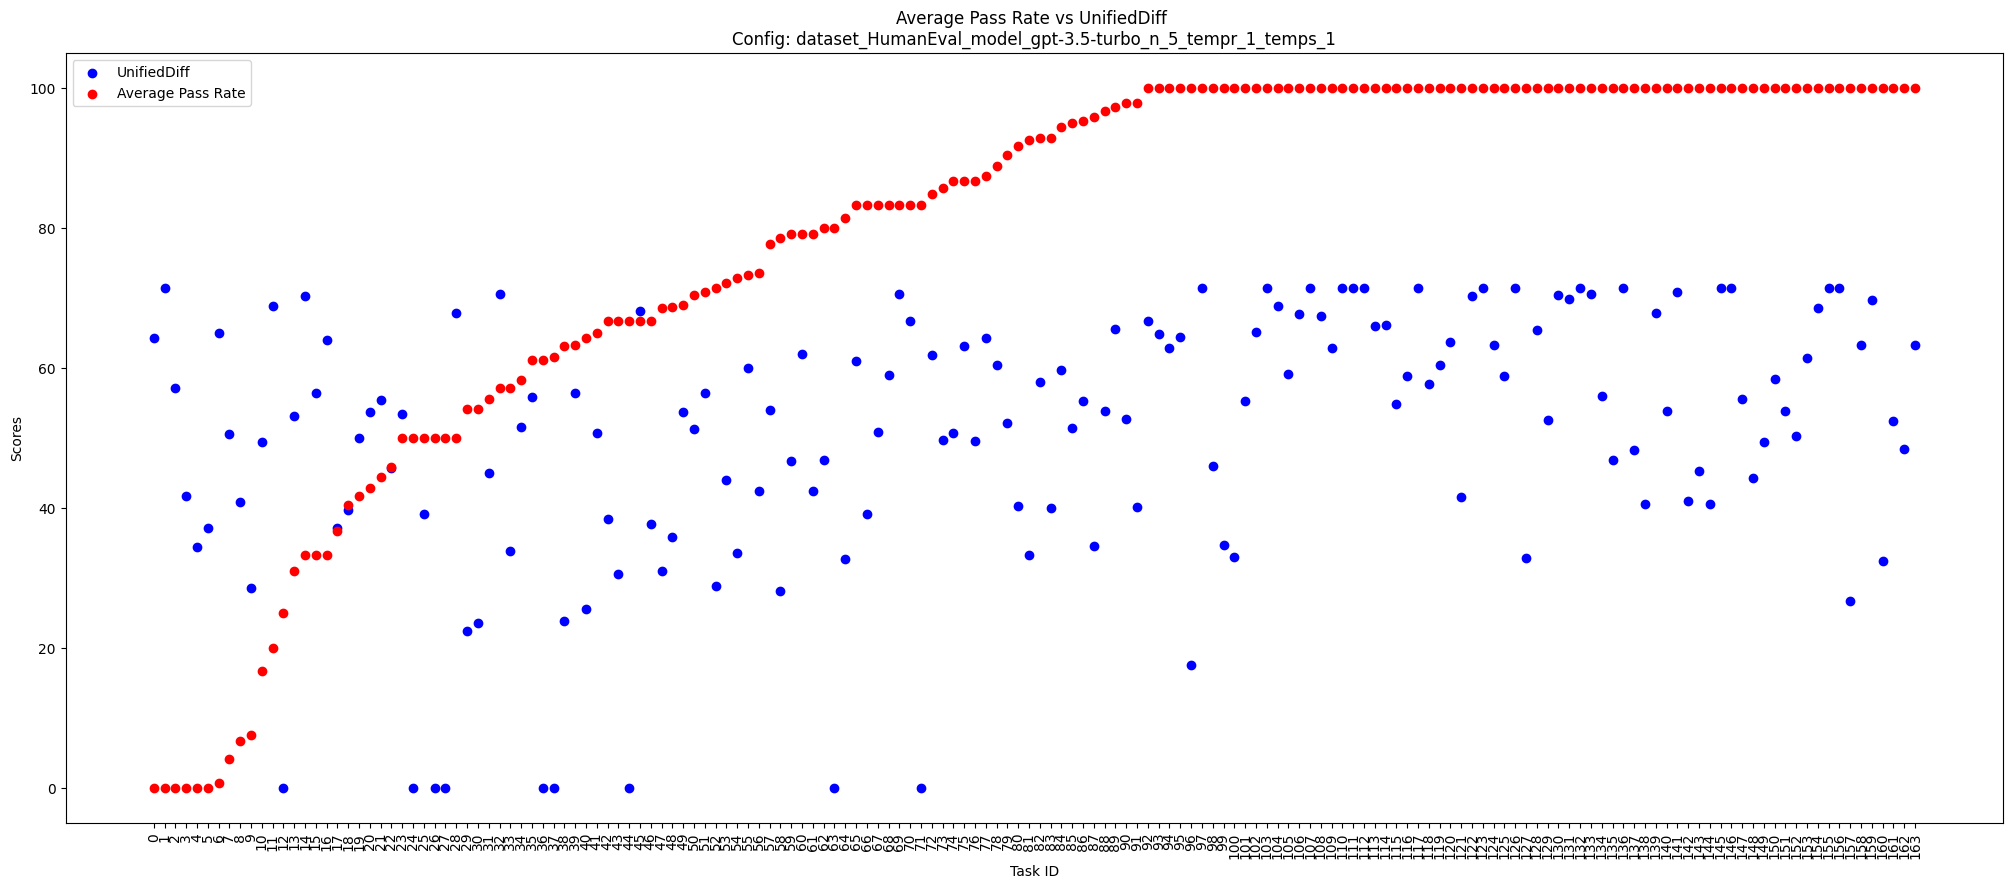

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_1_sim_score.csv  with a correlation of  0.2797874988226724
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_1_sim_score.csv
Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_1_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.3231707317073171
The correlation between the average pass rate and sequence_similarity is 0.30154212821944937


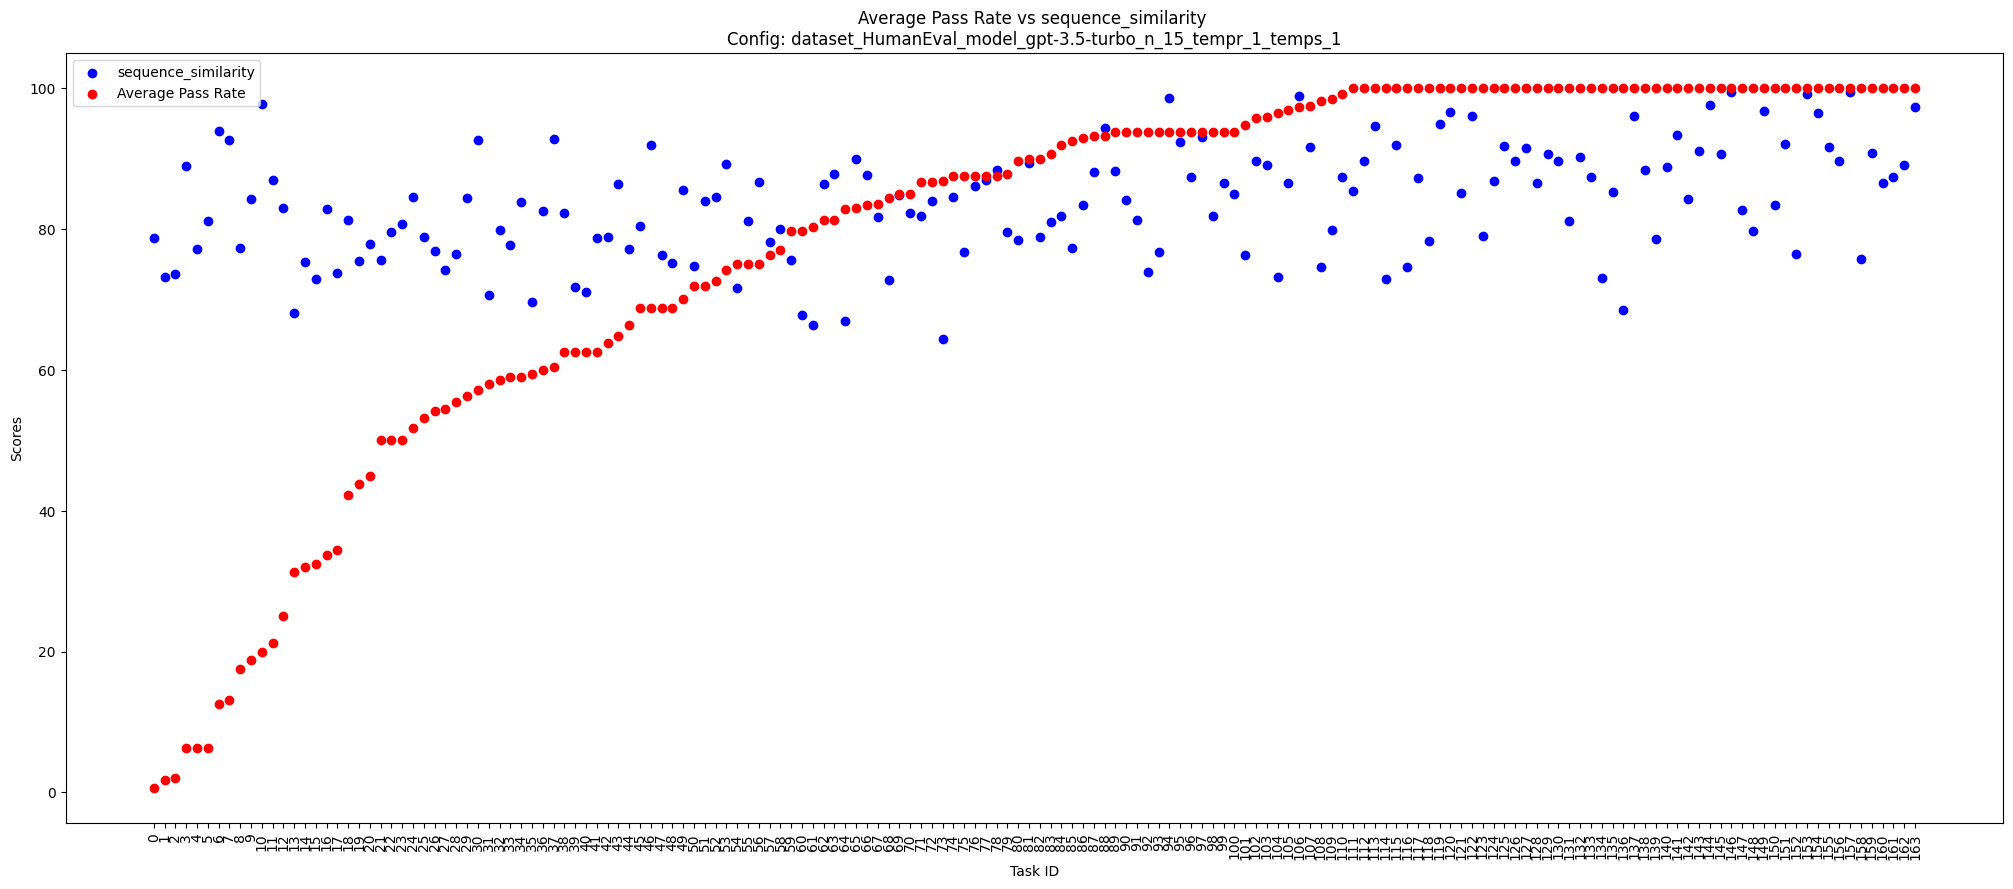

The correlation between the average pass rate and UnifiedDiff is 0.32501396413186096


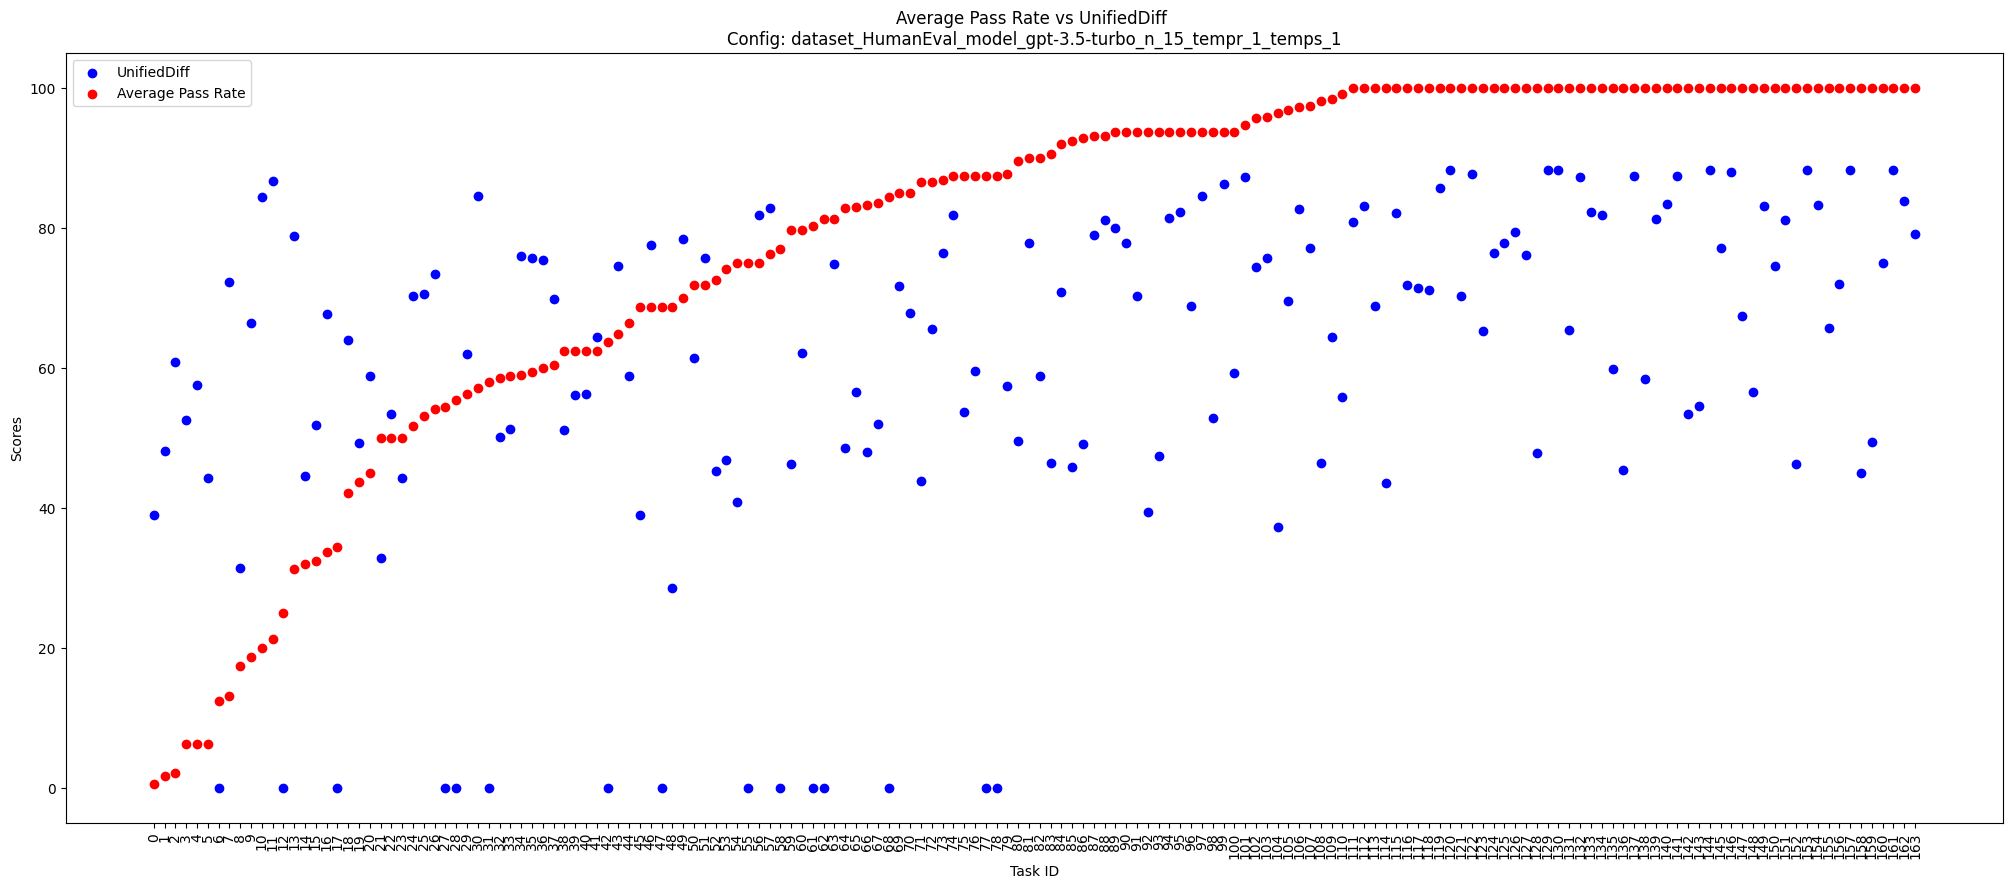

Visualizing the scores of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_1_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_1_temps_1_trial_1_sim_score.csv  with a correlation of  0.32501396413186096
generating stats of the file  ./RESULTS/final scores/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_1_temps_1_trial_1_sim_score.csv
Scores generated successfully


In [187]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('./RESULTS/final scores/*.csv')

stats =pd.DataFrame()
# Loop over the files and read them into pandas DataFrames
for file in csv_files:
    df = pd.read_csv(file)
    
    visualize(df,file)
    
    dict = {}

    dict = generate_stats(df,file)
    dict['file'] = file

    #generate a dataframe from the dict
    temp = pd.DataFrame(dict, index=[0])
    #reorder the columns to have the file column as the first column
    cols = temp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    temp = temp[cols]
    
    stats = pd.concat([stats,temp], ignore_index=True)

print("Scores generated successfully")

# exporting the stats to CSV and Excel files

In [167]:
stats = (stats.T)
stats.to_csv("RESULTS/stats.csv", index=True)
stats.to_excel("RESULTS/stats.xlsx", index=True)

In [168]:
stats

,0,1,2,3,4,5,6,7
file,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...
sequence_similarity,0.28,0.28,0.23,0.47,0.35,0.09,0.21,0.3
edit_distance_score,0.27,0.27,0.19,0.43,0.34,0.08,0.19,0.28
jaccard_similarity,0.23,0.27,0.17,0.4,0.29,0.13,0.16,0.3
cosine_similarity_score,0.28,0.26,0.16,0.43,0.24,0.1,0.21,0.3
sorensen_dice_coefficient,0.1,0.11,0.07,0.25,0.09,-0.03,0.05,0.19
hamming_distance_score,0.17,0.19,0.07,0.3,0.22,0.08,0.08,0.18
longest_common_subsequence,0.24,0.24,0.14,0.35,0.27,0.08,0.14,0.26
UnifiedDiff,0.3,0.25,0.3,0.42,0.27,0.15,0.28,0.33
TreeDiff,0.28,0.24,0.22,0.37,0.23,0.12,0.25,0.28
